In [2]:
from pathlib import Path
from ardi.dataset import SocialVAEDataset
import numpy as np
from ardi.prediction import LinearPredictor, PowerlawPredictor, SocialVAEPredictor, VelocityCalc, PrefVelocityCalc, Predictor

/home/alex/.local/share/virtualenvs/ardi-RqNcZ39U/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
test_ds = SocialVAEDataset("../../SocialVAE/data/zucker_day_controller_scene/19/cadrl/overtake/23_0.txt")

In [4]:
lp = LinearPredictor(8, VelocityCalc.LAST_DISPLACEMENT)
pp = PowerlawPredictor(8, VelocityCalc.LAST_DISPLACEMENT, PrefVelocityCalc.FIX_MAG_ORACLE_DIR)
sp = SocialVAEPredictor("../../SocialVAE/models/zara01/ckpt-best", 4, 5, 8, VelocityCalc.LAST_DISPLACEMENT, "cpu")
predictors = {
    "Linear": lp,
    "Powerlaw": pp,
    "SocialVAE": sp
}

lp_ades, lp_fdes = lp.predict_dataset(test_ds, 5, [i for i in test_ds.agents if i != -1], False)
pp_ades, pp_fdes = pp.predict_dataset(test_ds, 5, [i for i in test_ds.agents if i != -1], False)
sp_ades, sp_fdes = sp.predict_dataset(test_ds, 5, [i for i in test_ds.agents if i != -1], False)

print(np.mean(lp_ades), np.mean(lp_fdes))
print(np.mean(pp_ades), np.mean(pp_fdes))
print(np.mean(sp_ades), np.mean(sp_fdes))

3.1445721622873704 5.692209585648802
0.2297543604784849 0.37006448538139813
0.20786477077296284 0.43129064850663734


In [5]:
%matplotlib inline

from tqdm import tqdm
from typing import Dict, Tuple, List

results = {}

def get_results(predictors: Dict[str, Predictor], root: str, glob: str, plot: bool) -> Dict[str, Dict[str, Tuple[List[float], List[float]]]]:
    for i, fn in tqdm(list(enumerate(Path(root).glob(glob)))):
        day, controller, scene = str(fn).split("/")[5:8]
        idx, offset = fn.stem.split("_")
        img_root = Path(f"./{controller}/{scene}")
        img_root.mkdir(parents=True, exist_ok=True)
        
        ds = SocialVAEDataset(str(fn))
        results[str(fn)] = {}

        for name in predictors:
            ade, fde = predictors[name].predict_dataset(
                ds,
                5,
                [i for i in ds.agents if i != -1],
                plot,
                str(img_root) + f"/{day}_{idx}_{offset}_{name.lower()}",
                name + " " + controller + " on " + scene
            )

            results[str(fn)][name] = ade, fde
        
    return results

In [ ]:
from scipy.stats import normaltest

def is_normal(data: np.ndarray, alpha: float=0.05) -> bool:
    _, p = normaltest(data)
    return p > alpha

def get_results_normalicy(results: Dict[str, Dict[str, Tuple[List[float], List[float]]]]):
    linears = [x for x in [results[key]["Linear"][0] for key in results] for x in x]
    powerlaws = [x for x in [results[key]["Powerlaw"][0] for key in results] for x in x]
    socials = [x for x in [results[key]["SocialVAE"][0] for key in results] for x in x]

    return {
        "Linear": is_normal(linears),
        "Powerlaw": is_normal(powerlaws),
        "SocialVAE": is_normal(socials)
    }

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()

def plot_results(results: Dict[str, Dict[str, Tuple[List[float], List[float]]]], title: str):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    plot_fn = sns.kdeplot

    plot_fn([x for x in [results[key]["Linear"][0] for key in results] for x in x], label="Linear", ax=axs[0])
    plot_fn([x for x in [results[key]["SocialVAE"][0] for key in results] for x in x], label="SocialVAE", ax=axs[0])
    plot_fn([x for x in [results[key]["Powerlaw"][0] for key in results] for x in x], label="Powerlaw", ax=axs[0])

    plot_fn([x for x in [results[key]["Linear"][1] for key in results] for x in x], label="Linear", ax=axs[1])
    plot_fn([x for x in [results[key]["SocialVAE"][1] for key in results] for x in x], label="SocialVAE", ax=axs[1])
    plot_fn([x for x in [results[key]["Powerlaw"][1] for key in results] for x in x], label="Powerlaw", ax=axs[1])

    axs[0].set_ylabel("ADE Density")
    axs[1].set_ylabel("FDE Density")

    plt.suptitle(title)
    plt.legend()

In [27]:
import pandas as pd

def df_results(results: Dict[str, Dict[str, Tuple[List[float], List[float]]]]):
    data = []
    for fn in results:
        infos = fn.split("/")
        controller = infos[-3]
        scene = infos[-2]
        file = infos[-1]
        for pred in results[fn]:
            data.append({
                "scene": scene,
                "predictor": pred,
                "filename": file,
                "controller": controller,
                "ade": np.mean(results[fn][pred][0]),
                "fde": np.mean(results[fn][pred][1]),
            })

    return pd.DataFrame(data)

df_results(results).groupby(["scene", "predictor"]).agg(["mean", "sem"])

/tmp/ipykernel_20411/3185985465.py:22: FutureWarning: ['filename', 'controller'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_results(results).groupby(["scene", "predictor"]).agg(["mean", "sem"])


ade                 fde          
                            mean       sem      mean       sem
scene        predictor                                        
2v1          Linear     3.450385  0.021212  6.171933  0.038753
             Powerlaw   0.174028  0.006734  0.311100  0.011788
             SocialVAE  0.189858  0.002303  0.409701  0.005357
3v1 90       Linear     3.096968  0.017311  5.524787  0.030293
             Powerlaw   0.162190  0.007549  0.306514  0.015343
             SocialVAE  0.175318  0.004355  0.351335  0.008129
3v1 adjacent Linear     3.044226  0.019956  5.449274  0.035241
             Powerlaw   0.309726  0.004384  0.605071  0.012777
             SocialVAE  0.198825  0.004535  0.397357  0.010256
3v1 opposite Linear     3.069173  0.018370  5.486943  0.033084
             Powerlaw   0.271743  0.007217  0.515838  0.017253
             SocialVAE  0.189976  0.002332  0.384621  0.006034
head-to-head Linear     3.451056  0.022854  6.190798  0.043053
             Powerlaw   0.277177  0.016488  0.486287  0.031378
             SocialVAE  0.165234  0.002585  0.319497  0.007061
intersection Linear     3.301016  0.014896  5.914903  0.028206
             Powerlaw   0.199501  0.004423  0.336109  0.007768
             SocialVAE  0.292232  0.004953  0.542815  0.009375
overtake     Linear     3.173309  0.029478  5.681318  0.055388
             Powerlaw   0.171884  0.008091  0.282354  0.013680
             SocialVAE  0.258976  0.005249  0.474229  0.006587

In [8]:
results = get_results(predictors, "../../SocialVAE/data/zucker_day_controller_scene/", "./*/cadrl/*/*txt", False)
plot_results(results, "CADRL on All Scenarios")
print(get_results_normalicy(results))

  9%|▉         | 73/816 [08:00<40:57,  3.31s/it]  

100%|██████████| 384/384 [31:52<00:00,  4.98s/it]


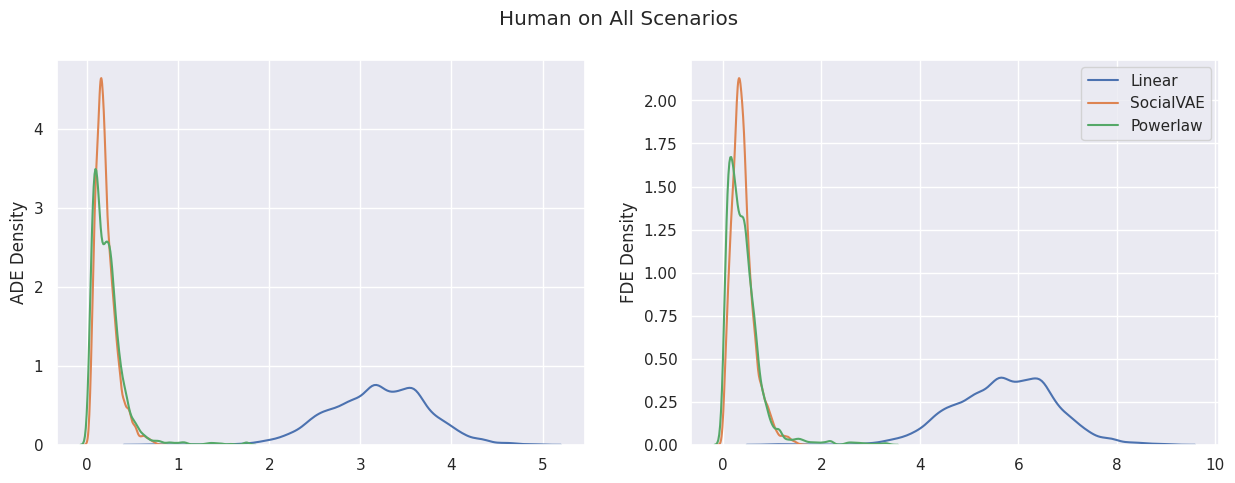

In [14]:
results = get_results(predictors, "../../SocialVAE/data/zucker_day_controller_scene/", "./*/human/*/*txt", False)
plot_results(results, "Human on All Scenarios")